# ASCAD with countermeasures

In [5]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tqdm.keras import TqdmCallback

from src.dlla.hw import NUM_CLASSES, plot_predictions, dlla_hw, dlla_p_gradient, prepare_traces_dl
from src.dlla.wegener import make_mlp_wegener, wegener_p_gradient
from src.tools.lists import random_divide, randomize
from src.tools.plotter import init_plots, plot_p_gradient, PALETTE_GRADIENT, store_sns
from src.trace_set.database import Database
from src.trace_set.pollution import Pollution, PollutionType
from src.trace_set.set_hw import TraceSetHW
from src.trace_set.transform import reduce_fixed_fixed
from src.tvla.tvla import Tvla

init_plots()

TRACE_LENGTH = 1400

In [7]:
ERROR = 'desynchronisation, $\sigma$ = 2.0'
# ERROR = 'jitter, $\lambda$ = 0.75'

POLL_TYPES = {
    'desynchronisation, $\sigma$ = 2.0': Pollution(PollutionType.desync, 2),
    'jitter, $\lambda$ = 0.75': Pollution(PollutionType.jitter, .75)
}

ascad = TraceSetHW(Database.ascad, POLL_TYPES[ERROR]).open('r')
TRACES, HW = np.array(ascad['profile/traces']), np.array(ascad['profile/hw'])
TRACES_ATT, HW_ATT = np.array(ascad['attack/traces']), np.array(ascad['attack/hw'])

X9, Y9, X9_ATT, Y9_ATT = prepare_traces_dl(TRACES, HW, TRACES_ATT, HW_ATT)
(X2, Y2), (X2_ATT, Y2_ATT) = reduce_fixed_fixed(X9, Y9), reduce_fixed_fixed(X9_ATT, Y9_ATT)

ascad.close()

### Model creation

With model hyper-parameters to be optimized.

In [9]:
def make_mlp(x, y, x_attack, y_attack, params):
    mdl = Sequential()
    mdl.add(Dense(100, activation=params['activation'], input_shape=(x.shape[1],)))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(NUM_CLASSES, activation='softmax'))

    mdl.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    out = mdl.fit(x, y, shuffle=True, validation_data=(x_attack, y_attack), batch_size=params['batch_size'],
                  epochs=params['epochs'], verbose=False, callbacks=[TqdmCallback(verbose=0)])

    return out, mdl

### Brute-force Hyper parameter optimization

Talos brute-force scan for optimal hyperparameters

In [4]:
# import talos
#
# scan_obj = talos.Scan(x=x_prof,    y=y_prof,    x_val=x_att,    y_val=y_att,    model=make_mlp,    params=model_parameters,    experiment_name=".cache/talos", print_params=True)

### Fit model based on the optimal model found by Talos.

In [10]:
NUM_PROFILING = 50000

best_model = make_mlp(X9[:NUM_PROFILING], Y9[:NUM_PROFILING], X9_ATT, Y9_ATT, {
    'activation':'relu',
    'optimizer': Adam(learning_rate=0.001),
    'losses': 'categorical_crossentropy',
    'batch_size': 150,
    'epochs': 5
})[1]

0epoch [00:00, ?epoch/s]

### HW Prediction

Predict the hamming weight by taking the weighted mean for the predicted probabilities for each class.

#### Example: Some prediction

Probabilities for each class:

In [11]:
best_model.predict(X9_ATT[:1])[0]

array([0.00705815, 0.03440231, 0.12257864, 0.1940347 , 0.23899408,
       0.23426694, 0.11851376, 0.04500256, 0.00514893], dtype=float32)

**Predicted hamming weight label**, calculated by taking the weighted mean using the predicted probabilities.

In [12]:
np.sum(best_model.predict(X9_ATT[:1])[0] * range(8 + 1))

4.056266564875841

In [13]:
dlla_hw(best_model, X9_ATT, Y9_ATT)

(0.5862610748798676, 0.8398874616072977)

### Plot p-gradient.

In [17]:
def split_traces(x, y):
    a = x[np.where(y < 4)]
    b = x[np.where(y > 4)]

    min_len = min(len(a), len(b))
    return a[:min_len], b[:min_len]

A_ATT, B_ATT = split_traces(TRACES_ATT, HW_ATT)

In [18]:
MAX_LEN = round(len(A_ATT) / 2)
TVLA_AB = Tvla(A_ATT.shape[1])
TVLA_AB.add(A_ATT[:MAX_LEN], B_ATT)
TVLA_BB = Tvla(TRACE_LENGTH)
TVLA_BB.add(*random_divide(B_ATT))

Computing min-p gradients: 100%|██████████| 3/3 [01:16<00:00, 25.55s/it]


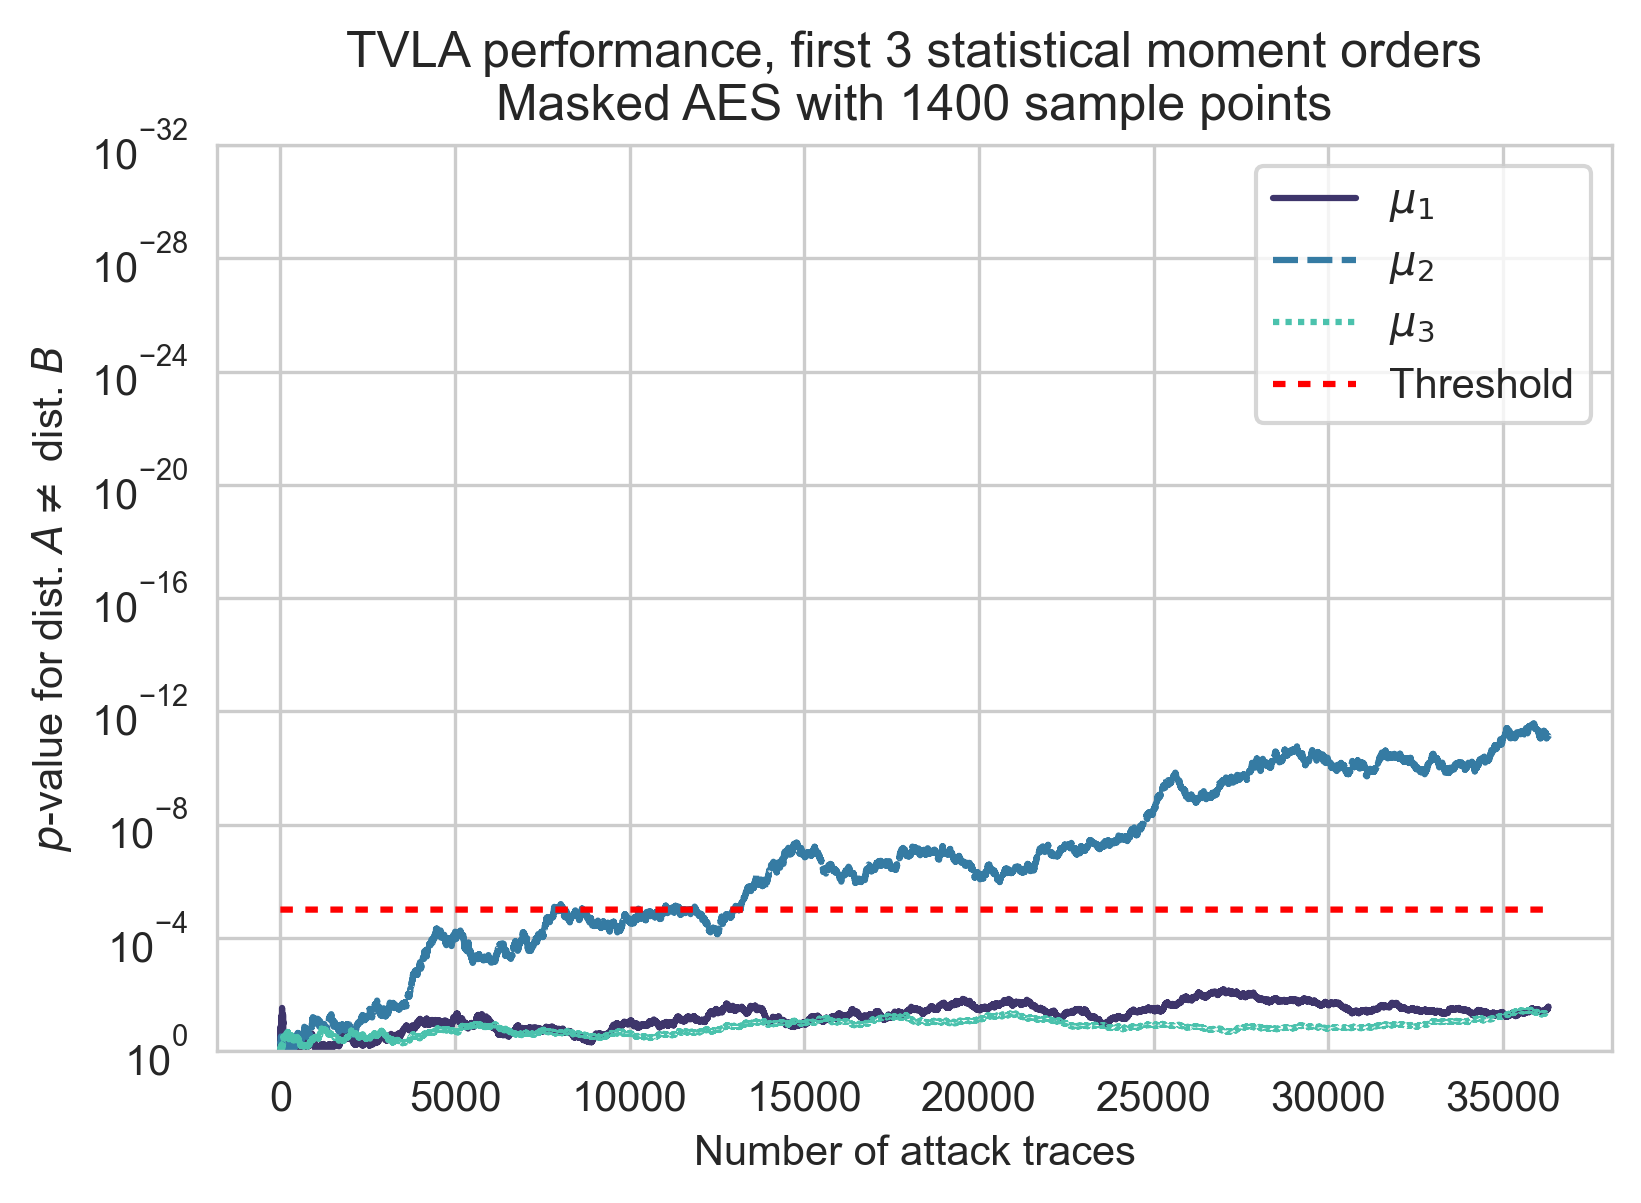

In [26]:
plot_p_gradient(dict([(f"$\\mu_{{{d}}}$", TVLA_AB.p_gradient(d)) for d in range(1, 4)]),
                "TVLA performance, first 3 statistical moment orders\nMasked AES with 1400 sample points", palette=PALETTE_GRADIENT)

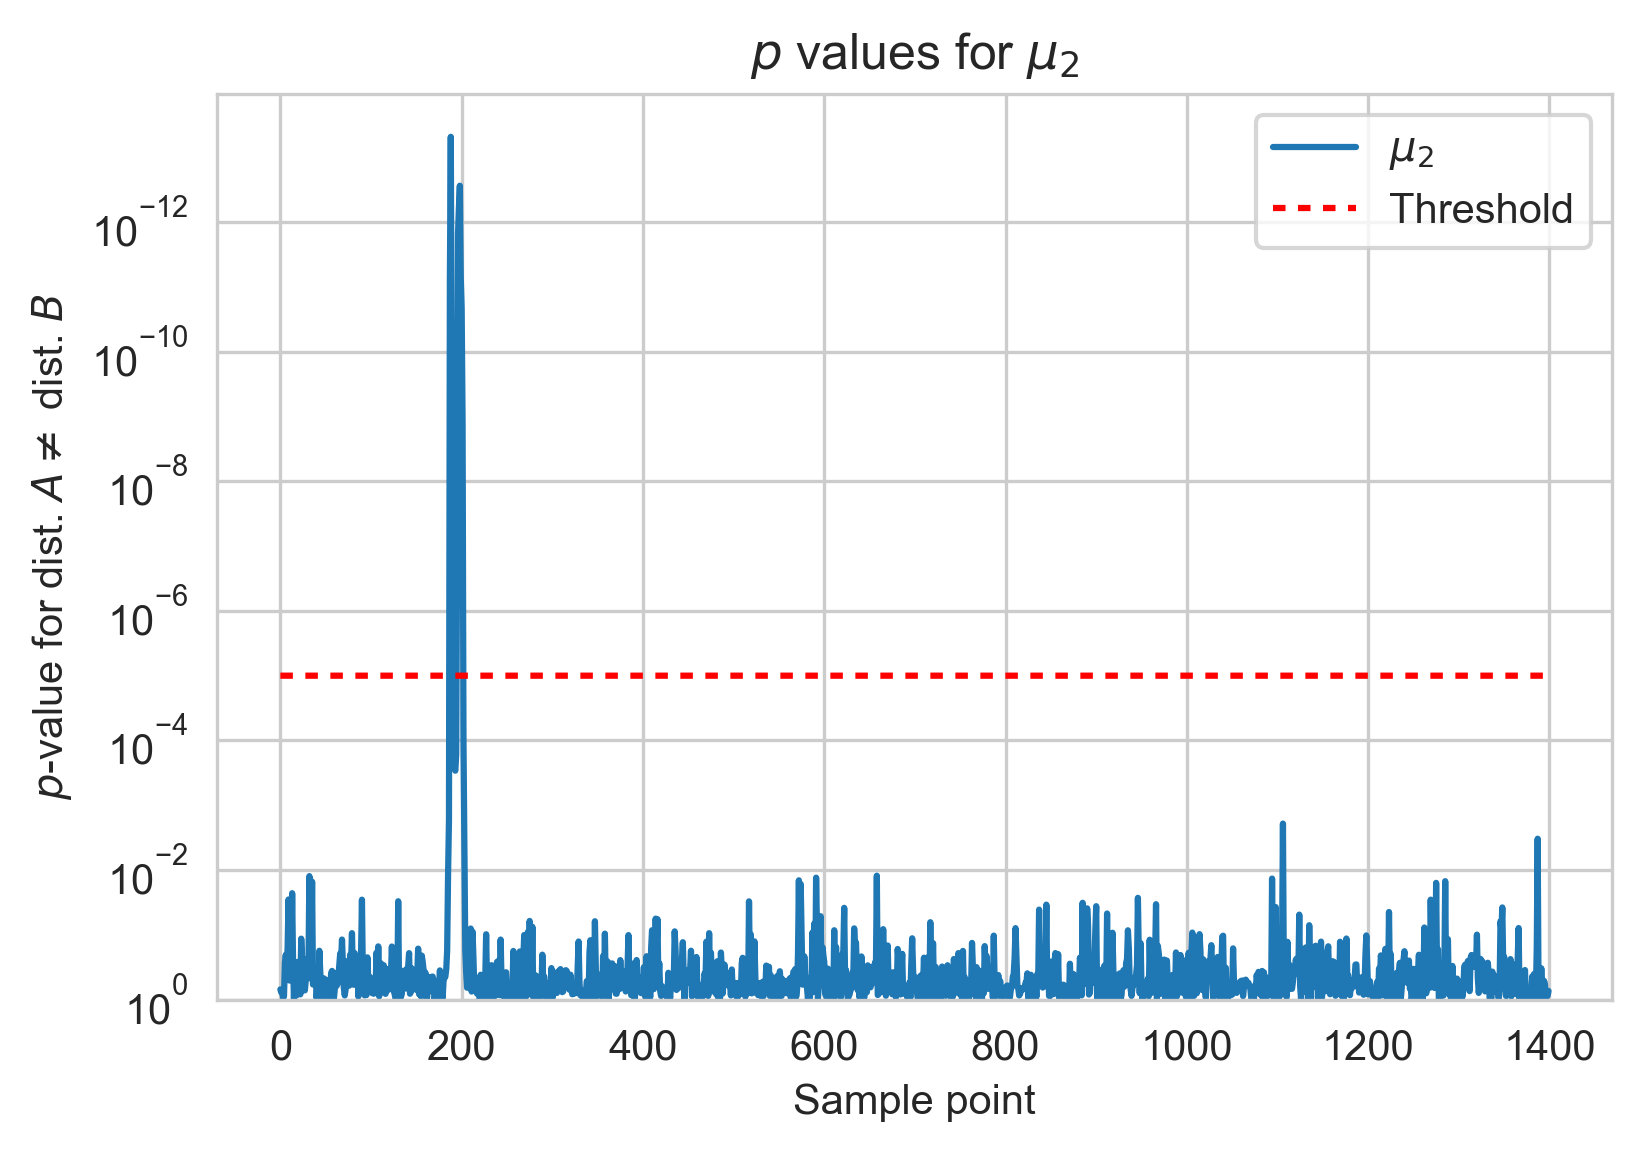

In [13]:
G = TVLA_AB.plot_min_p(2)
store_sns(G, "p-values-ascad")

<AxesSubplot:>

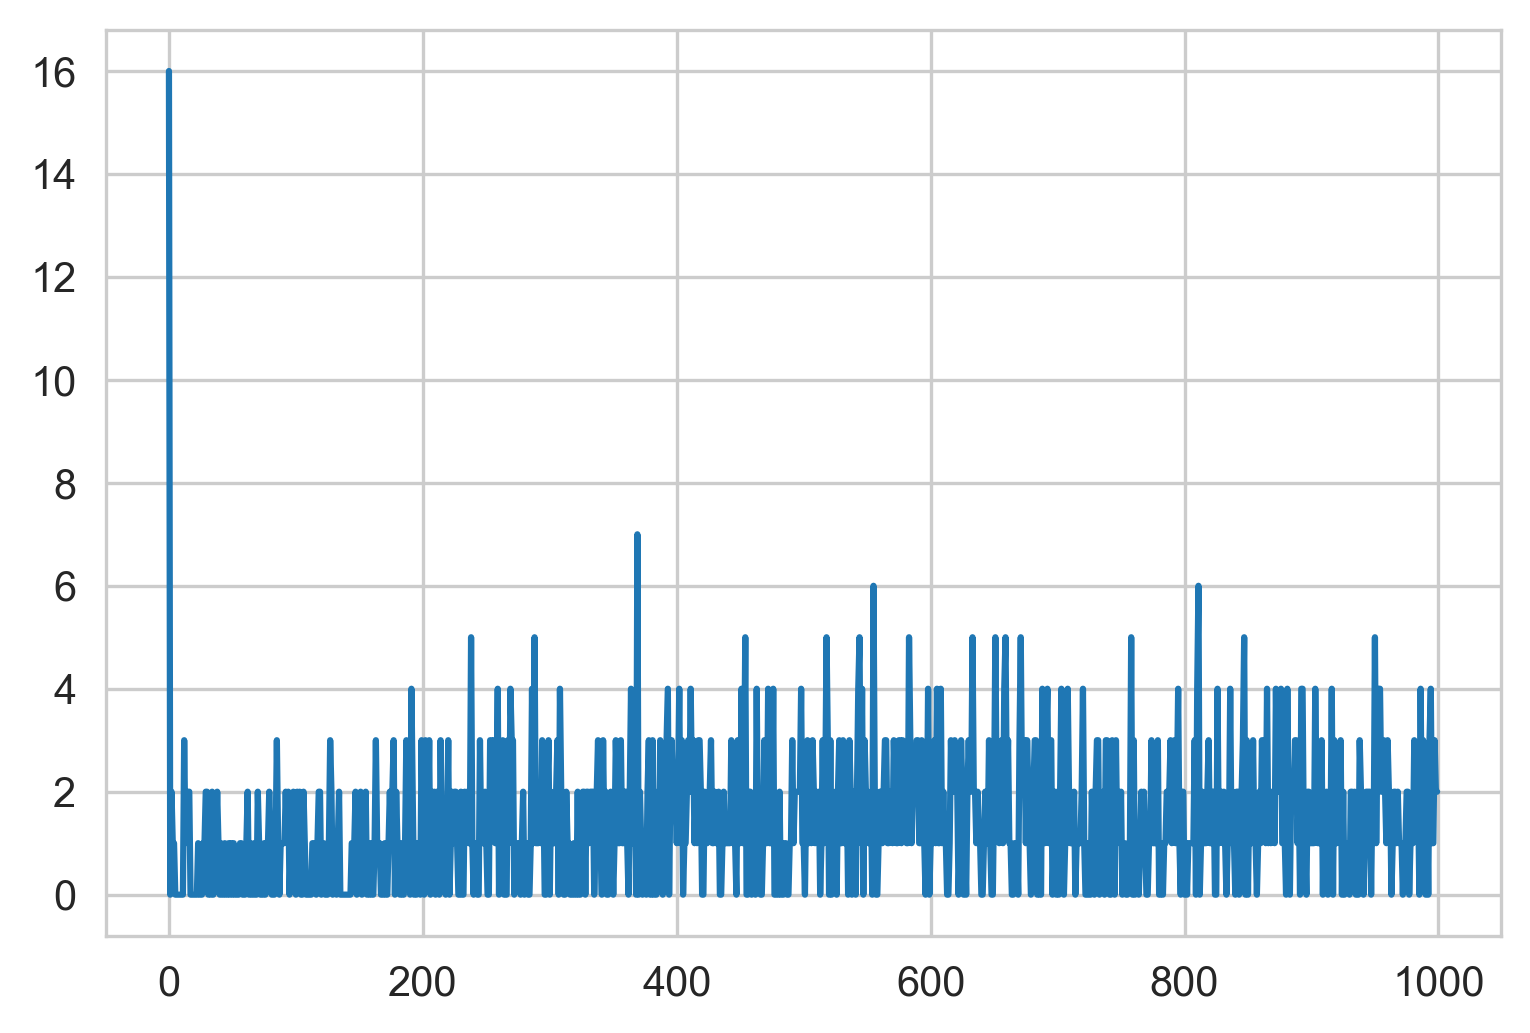

In [14]:
sns.lineplot(data=np.bincount(np.round(TVLA_AB.min_p[2] * 1000).astype(int), minlength=100))

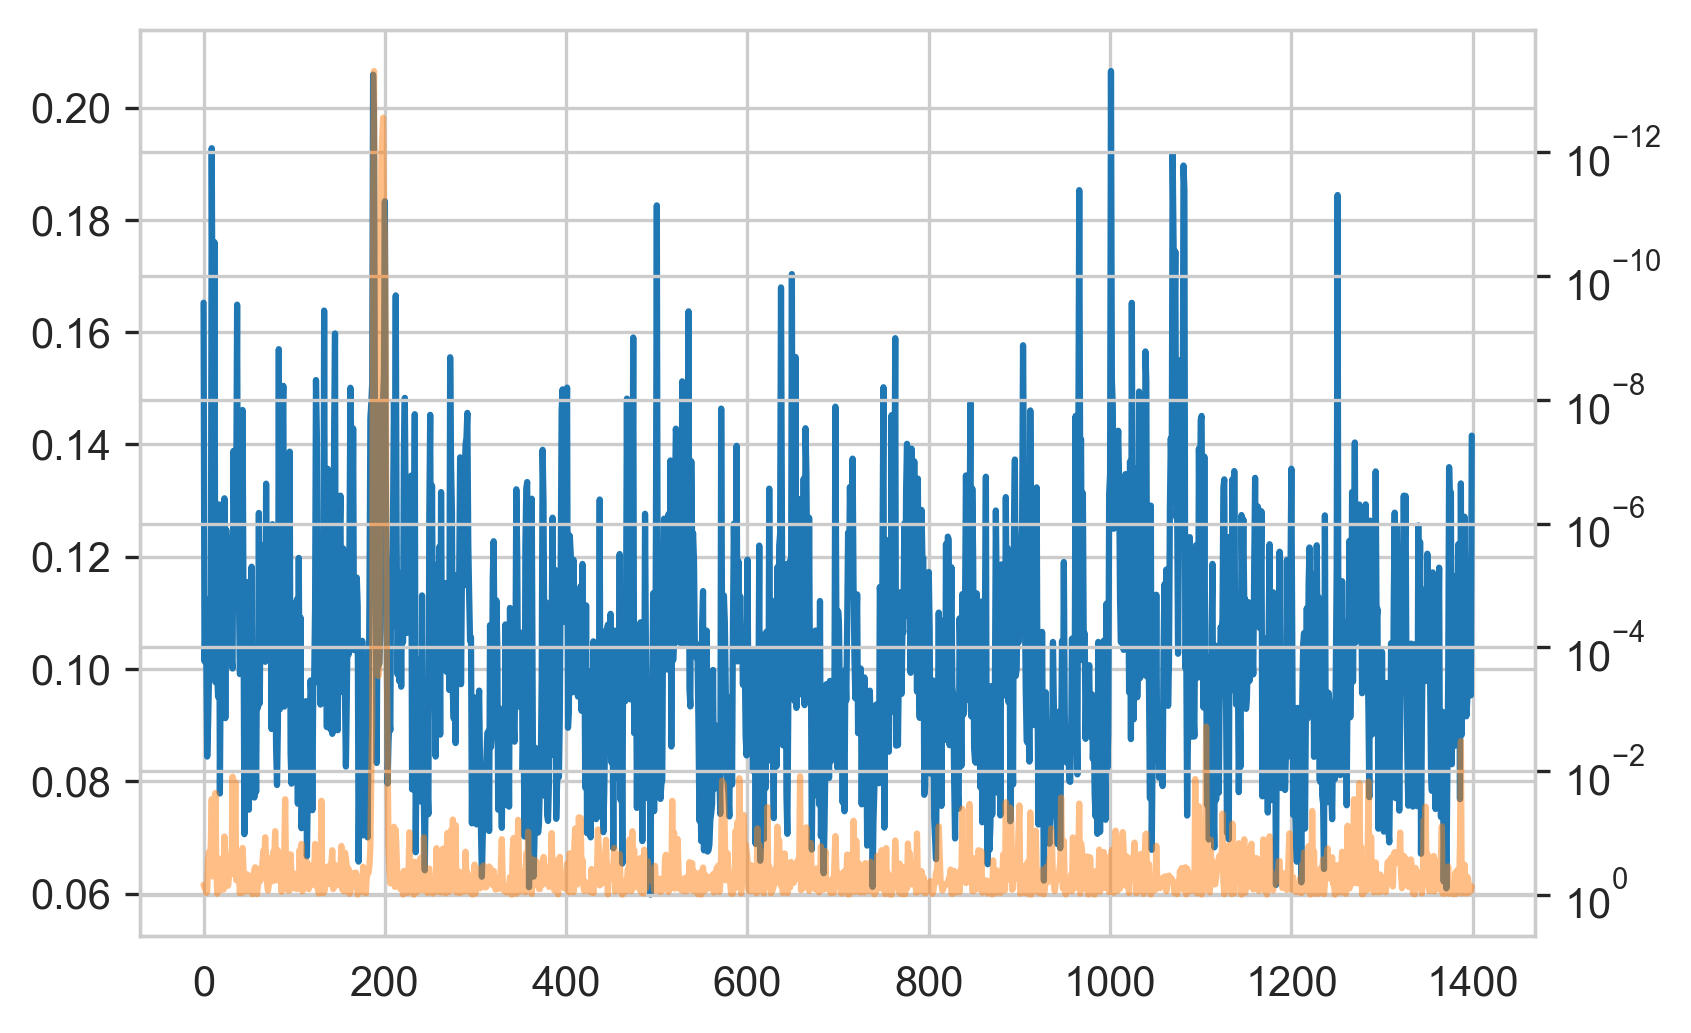

In [15]:
MAX_WEIGHTS = np.max(best_model.layers[0].get_weights()[0], axis=1)

sns.lineplot(data=MAX_WEIGHTS)
AX2 = plt.twinx()
G = sns.lineplot(data=TVLA_AB.min_p[2], ax=AX2, color=sns.color_palette()[1], alpha=.5)
G.set(yscale="log")
G.invert_yaxis()

In [16]:
print("p-value for uncorrelated system producing these datasets")
pearsonr(MAX_WEIGHTS, TVLA_AB.min_p[2])[1]

p-value for uncorrelated system producing these datasets


6.856622218489725e-06

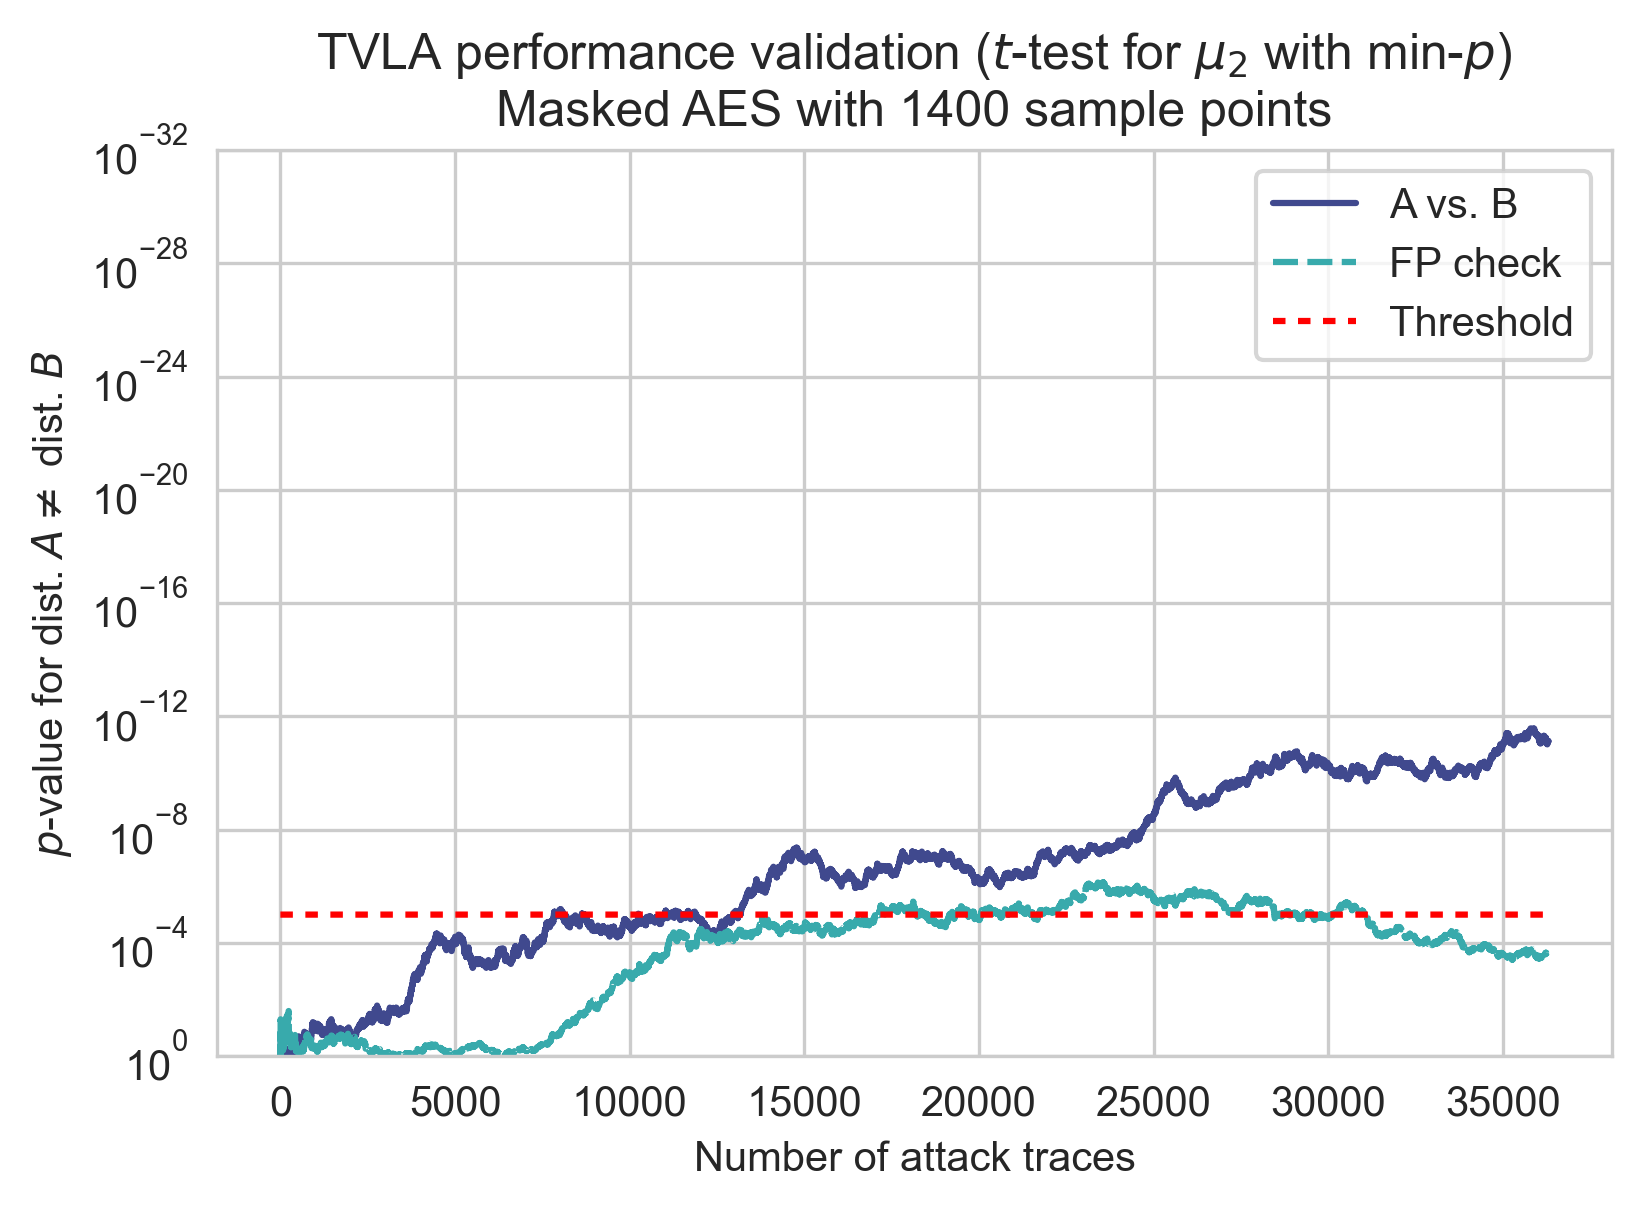

In [31]:
plot_p_gradient({
    "A vs. B": TVLA_AB.p_gradient(2),
    "FP check": TVLA_BB.p_gradient(2)
}, "TVLA performance validation ($t$-test for $\\mu_2$ with min-$p$)\nMasked AES with 1400 sample points",
    palette=PALETTE_GRADIENT,
    file_name="tvla-validation-mu2")

PG_LEN = len(TVLA_AB.p_gradient(2))

/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


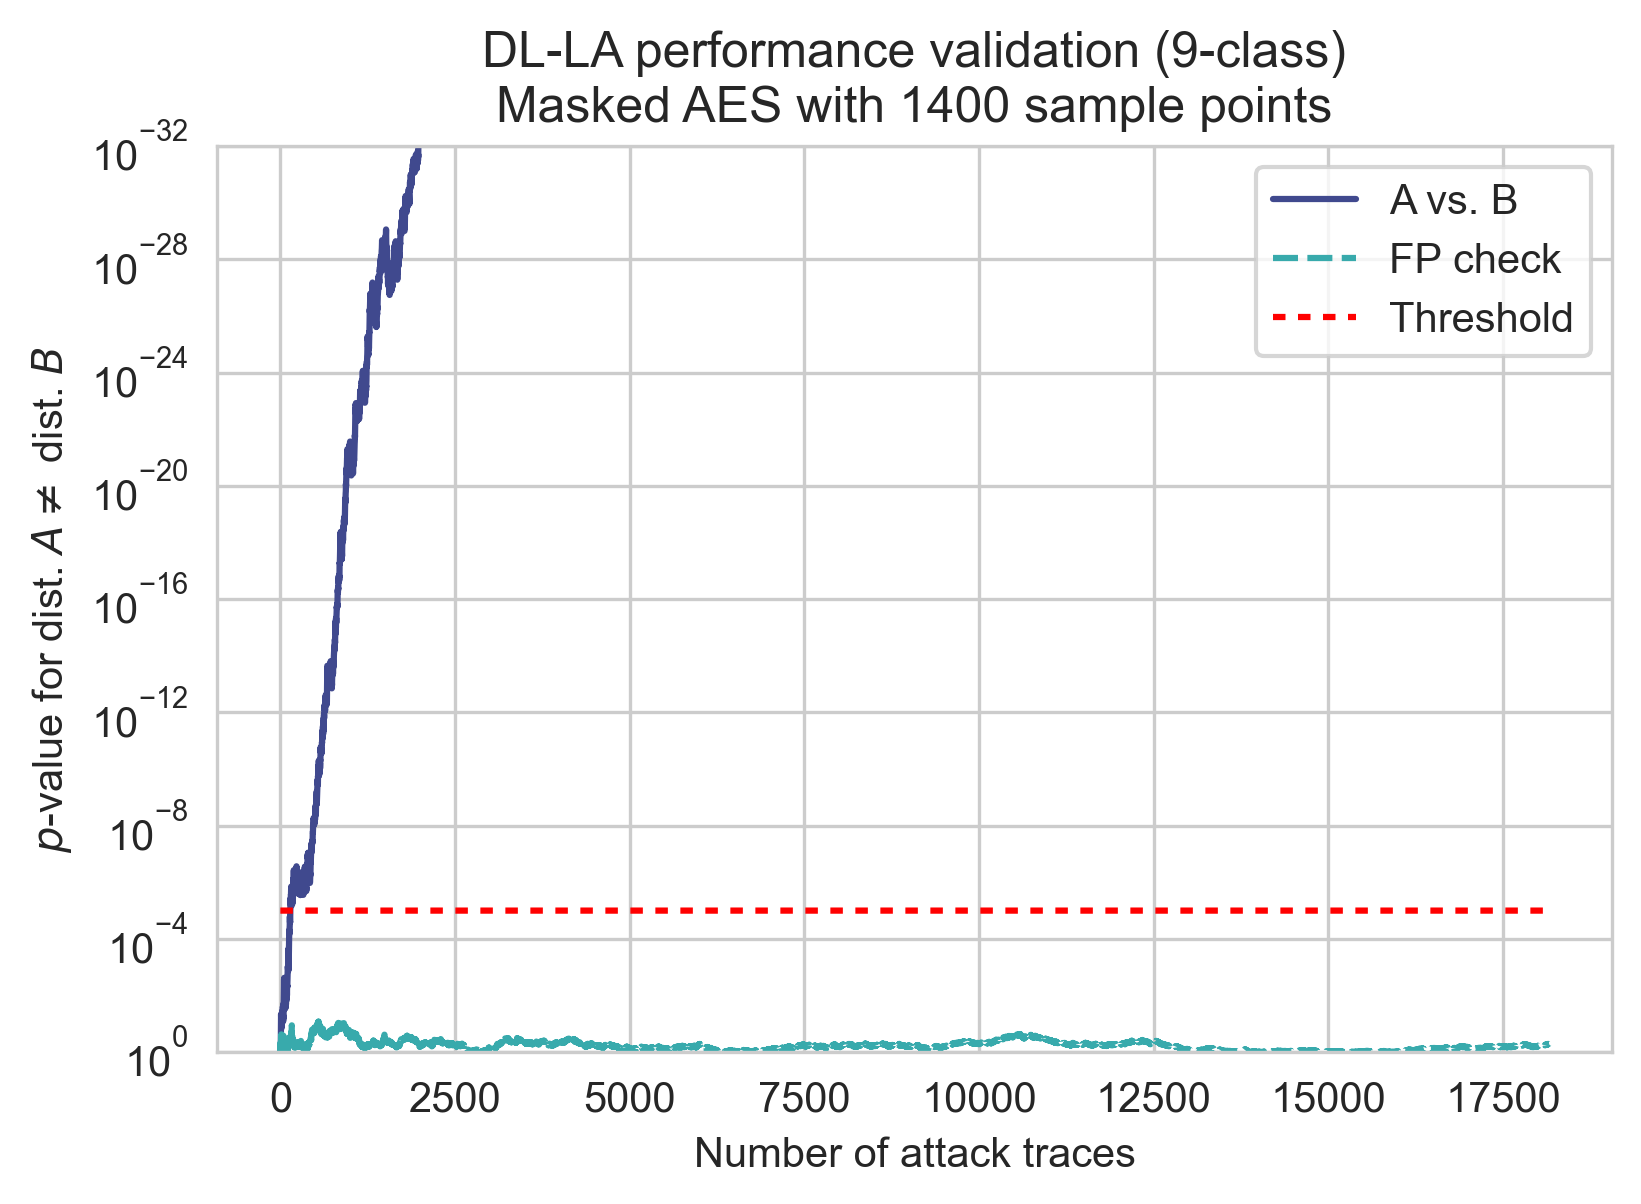

In [24]:
PG_DLLA_9 = dlla_p_gradient(best_model, x_att, y_att)["A vs. B"]
PG_DLLA_9_RANDOM = dlla_p_gradient(best_model, x_att, randomize(y_att))["A vs. B"]

plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_9),
    "FP check": np.array(PG_DLLA_9_RANDOM),
}, "DL-LA performance validation (9-class)\nMasked AES with 1400 sample points",
    palette=PALETTE_GRADIENT,
    file_name="dlla-9-validation"
)

In [19]:
X_PROF_2, Y_PROF_2 = reduce_fixed_fixed(x_prof, y_prof)
X_ATT_2, Y_ATT_2 = reduce_fixed_fixed(x_att, y_att)
Y_ATT_2_RANDOM = randomize(Y_ATT_2)

Epoch 1/5
334/334 [==============================] - 1s 4ms/step - loss: 0.2539 - accuracy: 0.5098 - val_loss: 0.2506 - val_accuracy: 0.5172

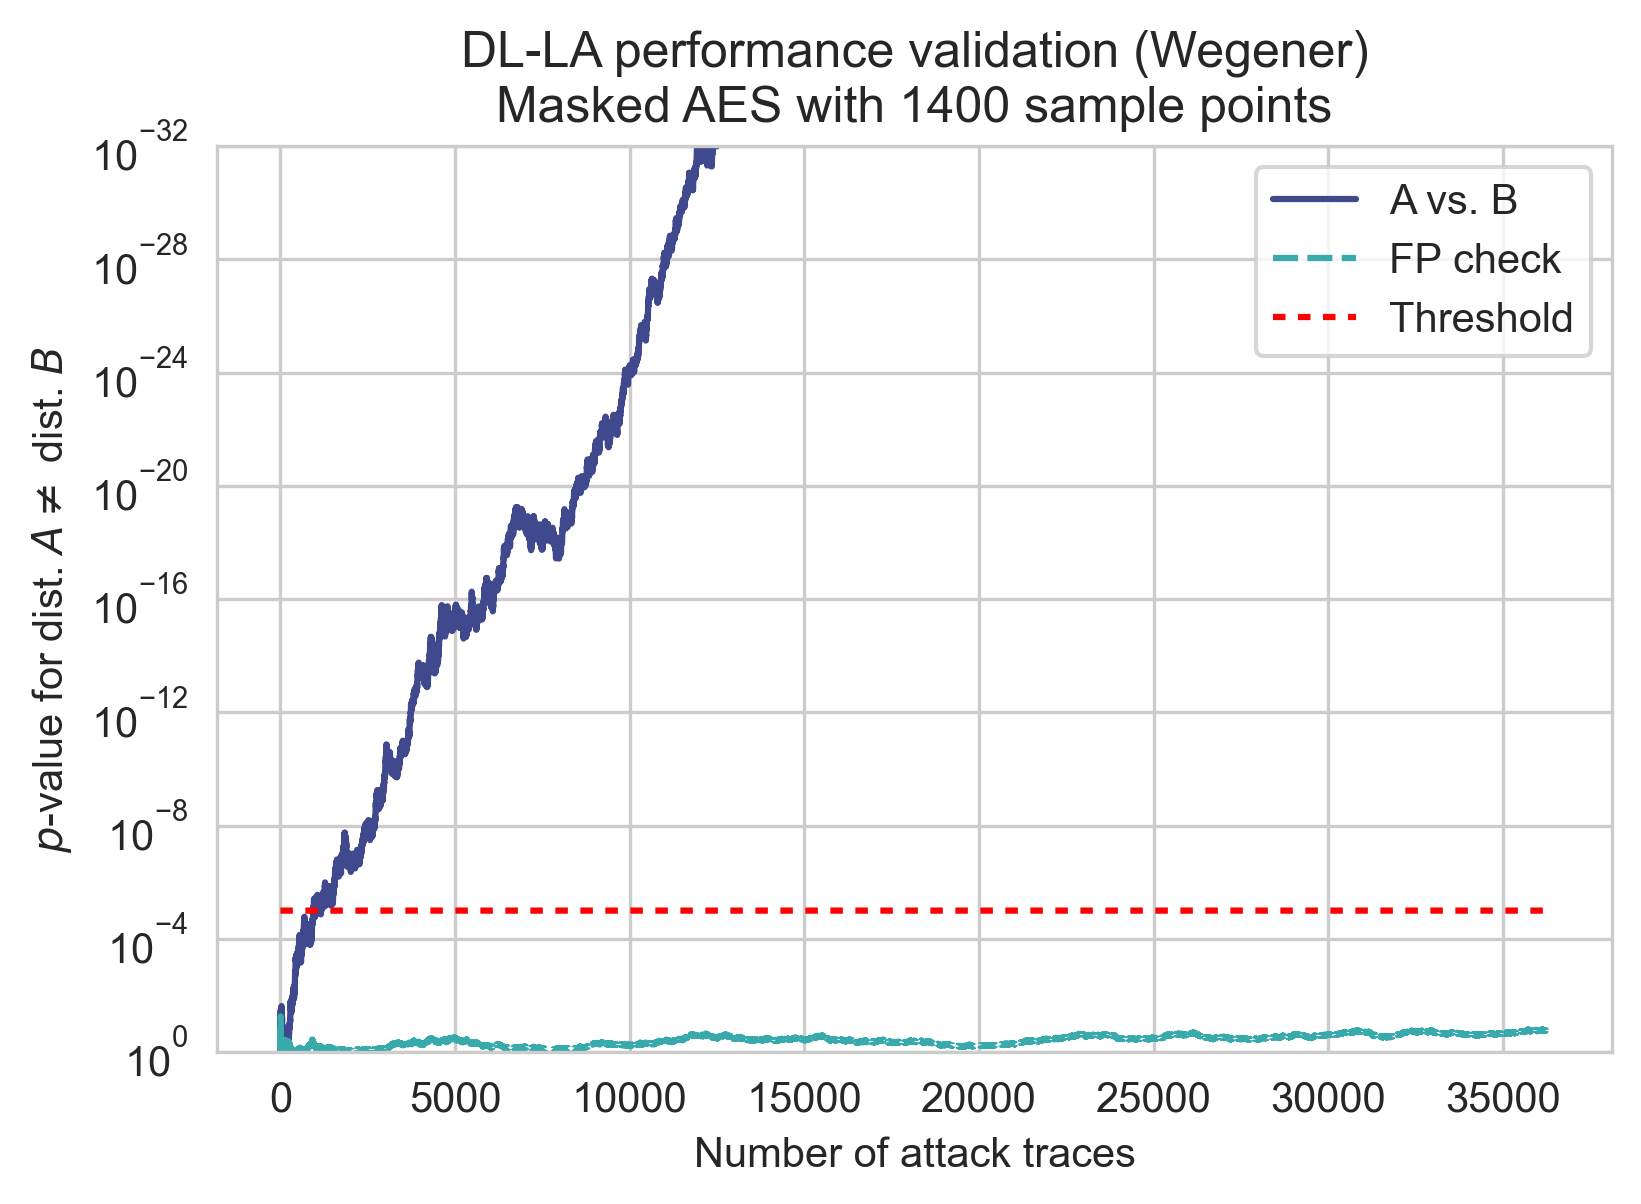

In [27]:
MODEL_WEGENER_AB = make_mlp_wegener(X_PROF_2[:NUM_PROFILING], Y_PROF_2[:NUM_PROFILING], X_ATT_2, Y_ATT_2)

PG_DLLA_2_AB = wegener_p_gradient(MODEL_WEGENER_AB, X_ATT_2[:PG_LEN], Y_ATT_2[:PG_LEN])
PG_DLLA_2_RANDOM =  wegener_p_gradient(MODEL_WEGENER_AB, X_ATT_2[:PG_LEN], Y_ATT_2_RANDOM[:PG_LEN])

plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_2_AB),
    "FP check": np.array(PG_DLLA_2_RANDOM),
}, "DL-LA performance validation (Wegener)\nMasked AES with 1400 sample points",
    palette=PALETTE_GRADIENT,
    file_name="dlla-2-validation"
)

### Experiment - performance using t-test distinguisher

In [21]:
# PG_DLLA_2_AB_T = wegener_t_test_p_gradient(MODEL_WEGENER_AB, X_ATT_2[:PG_LEN], Y_ATT_2[:PG_LEN])
# PG_DLLA_2_RANDOM_T = wegener_t_test_p_gradient(MODEL_WEGENER_AB, X_ATT_2[:PG_LEN], Y_ATT_2_RANDOM[:PG_LEN])

# plot_p_gradient({
#     "A vs. B": np.array(PG_DLLA_2_AB_T),
#     "FP check": np.array(PG_DLLA_2_RANDOM_T),
# }, "DL-LA performance validation (Wegener) on ASCAD.\nEvaluation using $t$-test",
#     palette=PALETTE_GRADIENT,
#     file_name="dlla-2-validation"
# )

# plot_p_gradient({
#     "Binomial test": np.array(PG_DLLA_2_AB[:4000]),
#     "t-test": np.array(PG_DLLA_2_AB_T[:4000]),
# }, "DL-LA performance (Wegener) on ASCAD.\nEvaluation using different statistical tests\n")

# plot_p_gradient({
#     "DL-LA (Wegener, binomial test)": np.array(PG_DLLA_2_AB),
#     "TVLA $\\mu_2$": TVLA_AB.p_gradient(2)
# },"LA method performance\nmasked AES with 1400 sample points\n")

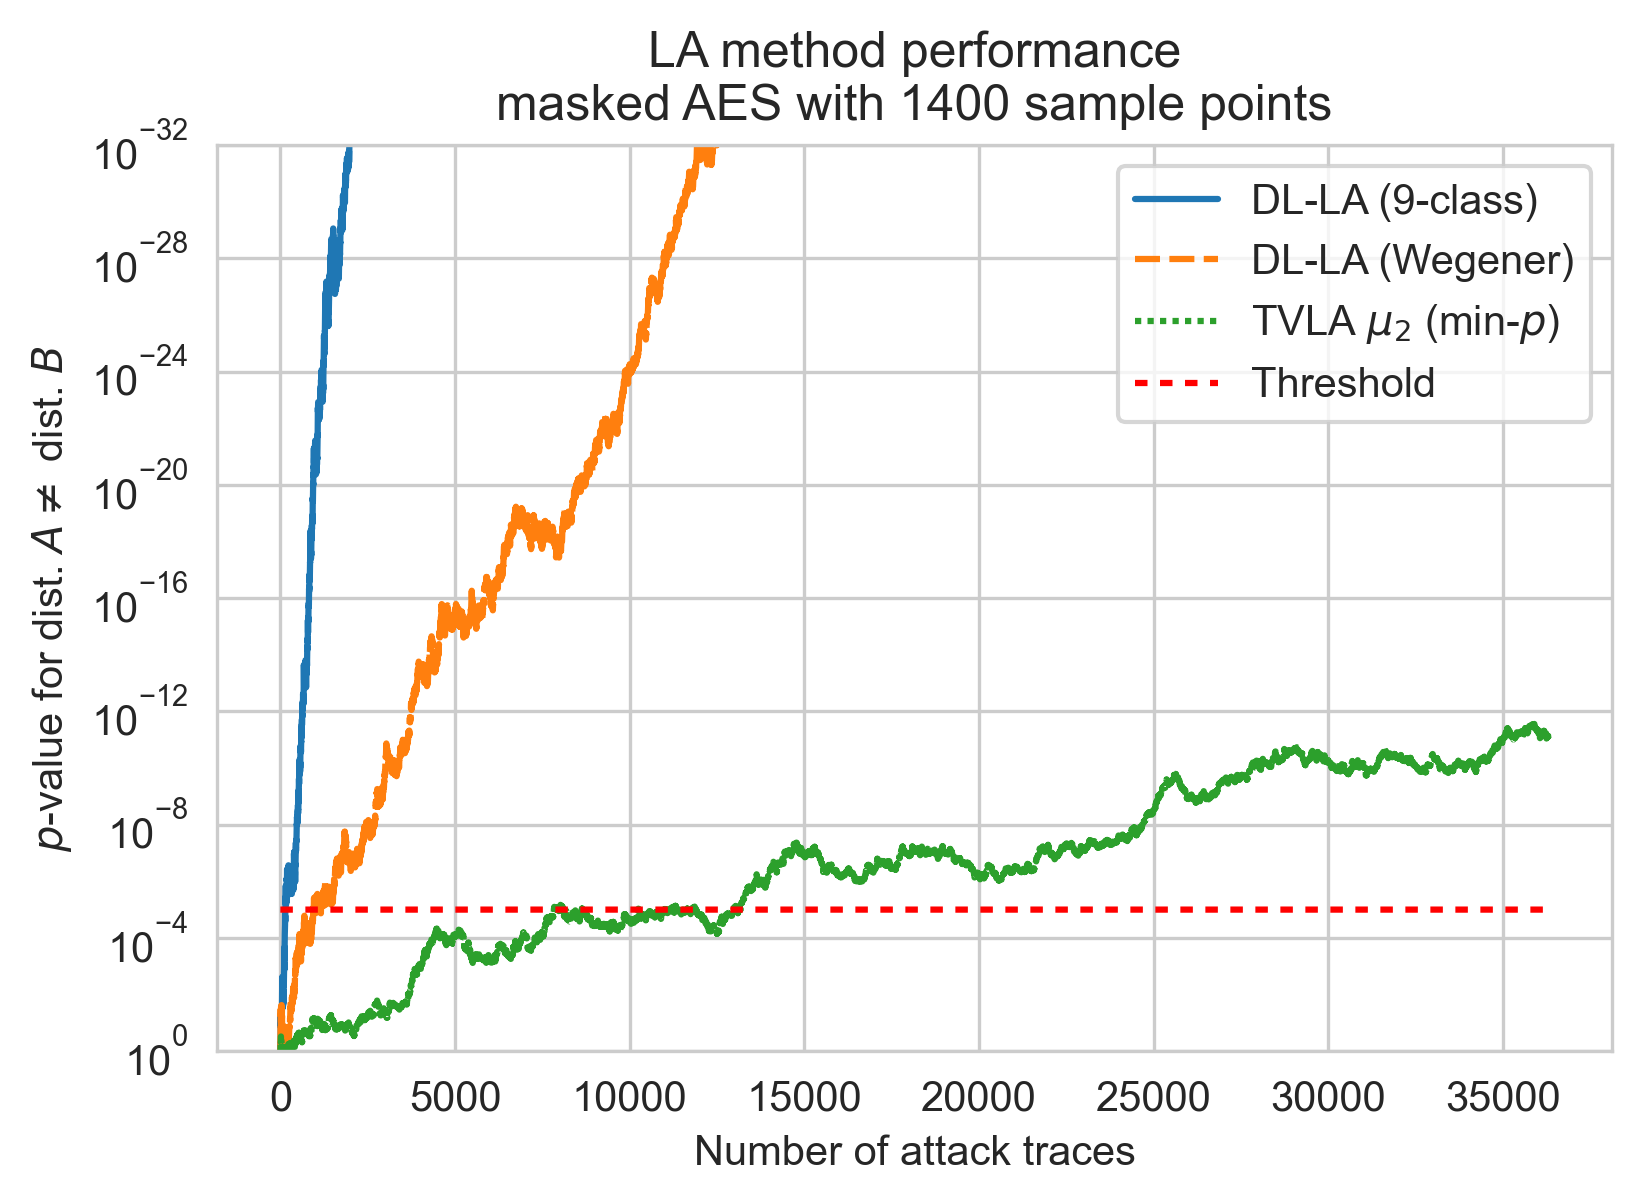

In [29]:
plot_p_gradient({
    "DL-LA (9-class)": np.array(PG_DLLA_9),
    "DL-LA (Wegener)": np.array(PG_DLLA_2_AB),
    "TVLA $\\mu_2$ (min-$p$)": TVLA_AB.p_gradient(2)
},"LA method performance\nmasked AES with 1400 sample points",
    file_name="ascad-default-all"
)